In [134]:
'''
def remove_dots(img, baseline, th, file_name): #th is the minimum number of pixels for it to not be a dot or hamza
    desired_lower_region_size = 9
    desired_higher_region_size = 15
    top_region_size = baseline if baseline - desired_higher_region_size < 0 else desired_higher_region_size
    bot_region_size = img.shape[0] - baseline + 1 if baseline + desired_lower_region_size + 1 > img.shape[0] else desired_lower_region_size
    cropped_img = img[baseline - top_region_size: baseline + bot_region_size, :]
    cv2.imwrite(file_name + '-cropped.png', cropped_img)
    visited = np.zeros(cropped_img.shape)
    for row in range(cropped_img.shape[0]):
        for col in range(cropped_img.shape[1]):
            if (cropped_img[row, col] != 255 or visited[row, col]):
                continue
            visited_copy = np.copy(visited)
            count = dfs(cropped_img, row, col, visited, False)
            print(count)
            if count <= th:
                _ = dfs(cropped_img, row, col, visited_copy, True)
                img[baseline - top_region_size: baseline + bot_region_size, :] = cropped_img
'''

In [170]:
from math import pi, sqrt, exp

def gauss(n=11,sigma=1):
    r = range(-int(n/2),int(n/2)+1)
    return [1 / (sigma * sqrt(2*pi)) * exp(-float(x)**2/(2*sigma**2)) for x in r]

def convolve(img, kernel):
    result = np.zeros(len(img))
    half_width = len(kernel) // 2
    for i in range(half_width, len(img) - half_width):
        val = 0
        for j in range(-half_width, half_width + 1):
            val += img[i + j] * kernel [j + half_width]
        result[i] = val
    return result

In [256]:
import cv2
import numpy as np
import numpy.ma as ma
import os, glob, re
import shutil
from scipy.fftpack import dct, idct
import matplotlib.pyplot as plt

#from scipy import ndimage
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts
results_path = 'C:/D/PDFS/College/4th year/1st term/Pattern Recognition/Project/Dataset/results'
char_path = 'C:/D/PDFS/College/4th year/1st term/Pattern Recognition/Project/Dataset/chars'
char_folder_path = 'C:/D/PDFS/College/4th year/1st term/Pattern Recognition/Project/Dataset/'

dx = [-1, 1, 0, 0, 1, -1, 1, -1]
dy = [0, 0, -1, 1, 1, -1, -1, 1]
#dx = [-1, 1, 0, 0]
#dy = [0, 0, -1, 1]

In [242]:
def is_valid(row, col, img_shape):
    if row < 0 or row >= img_shape[0] or col < 0 or col >= img_shape[1]:
        return False
    return True

In [251]:
def dfs(img, row, col, visited, remove):
    visited[row, col] = True
    count = 1
    for i in range(len(dx)):
        new_row = row + dx[i]
        new_col = col + dy[i]
        if is_valid(new_row, new_col, img.shape) and not visited[new_row, new_col] and img[new_row, new_col] == 255:
            new_count = dfs(img, new_row, new_col, visited, remove)
            count += new_count
    if remove:
        img[row, col] = 0
    return count

In [252]:
def remove_dots(img, baseline, th, file_name): #th is the minimum number of pixels for it to not be a dot or hamza
    visited = np.zeros(img.shape, dtype=bool)
    for col in range(img.shape[1]):
        if (img[baseline, col] != 255 or visited[baseline, col]):
            continue
        visited_copy = np.copy(visited)
        count = dfs(img, baseline, col, visited, False)
        if count <= th:
            _ = dfs(img, baseline, col, visited_copy, True)
    #cv2.imwrite(file_name+"before.png", img)
    img = img == 255
    return (np.logical_and(img, visited).astype('uint8')) * 255
    #cv2.imwrite(file_name+'after.png', img)

In [261]:
def segment_characters(img_name, folder_count, img_count):
    file_name = char_path + '/' + str(folder) + '/result' + str(img_count) + '/' + 'result' + str(folder_count) + '-' + str(img_count)
    img = cv2.imread(img_name, 0)  #0 parameter means read it in grayscale
    _, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)
    img_copy = img.copy()
    horizontal_profile = cv2.reduce(img, 1, cv2.REDUCE_SUM, dtype=cv2.CV_32S) #2nd param = 1 means row sum
    baseline_idx = np.argmax(horizontal_profile)
    dot_count_threshold = 6
    no_dots_img = remove_dots(img_copy, baseline_idx, dot_count_threshold, file_name)
    #no_dots_img = 255 - no_dots_img
    cv2.imwrite(file_name + "_no_dots.png", no_dots_img)
    vertical_profile = cv2.reduce(no_dots_img, 0, cv2.REDUCE_SUM, dtype=cv2.CV_32S)
    #print(vertical_profile)
    #result = convolve(vertical_profile[0], gauss(3, 0.1))
    #result = convolve(vertical_profile[0], [-1, -2, 0, 2, 1])
    #print(np.fft.fft(vertical_profile)[0][0:4])
    #print(vertical_profile[0][10:30])
    #idk = idct(dct(vertical_profile)[0][0:2], 2, n=len(vertical_profile[0]))
    #result = convolve(idk, [-1, 0, 1])
    results = np.abs(convolve(vertical_profile[0], [-1, 0, 1]))
    mask = np.zeros(len(results) - 1, dtype=bool)
    #print(result)
    mask = results <= 255
    for i in range(len(results) - 1):
        if mask[i] == True and mask[i+1] == True:
            mask[i] = False
    #print(result[mask])
    '''
    for i in range(len(vertical_profile[0]) - 1):
        if vertical_profile[0][i] == vertical_profile[0][i + 1]:
            cv2.line(img, (i, 0), (i, img.shape[0]), (255,0,0), 1)
    '''
    verticals = np.argwhere(mask == True)
    for x in verticals:
        cv2.line(img, (x[0], 0), (x[0], img.shape[0]), (255,0,0), 1)
    #print('result of convolution:')
    #print(result)
    cv2.imwrite(file_name + ".png", img)

result1
result0.png


NameError: name 'results' is not defined

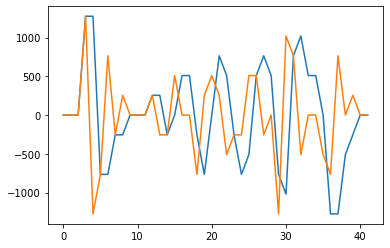

In [262]:
if os.path.exists(char_folder_path + 'chars'):
    shutil.rmtree(char_folder_path + 'chars', ignore_errors=True)
os.mkdir(char_folder_path + 'chars')
os.chdir(results_path)
for folder_count, folder in enumerate(os.listdir()):
    if (folder_count >= 1):
        break
    os.mkdir(char_path + '/' + str(folder))
    print(folder)
    os.chdir(folder)
    for img_count, img_name in enumerate(sorted(os.listdir(), key=numericalSort)):
        if (img_count >= 20):
            break
        os.mkdir(char_path + '/' + str(folder) + '/result' + str(img_count))
        print(img_name)
        segment_characters(img_name, folder_count, img_count)
    os.chdir('..')

In [224]:
zz = np.array([[False ,True], [False, False]])
bb = np.array([[255, 255], [255, 255]])

In [158]:
def zzz(z, b):
    return ma.masked_array(b, z).data

In [212]:
zzz(zz, bb)

array([[255, 255],
       [255, 255]])

In [257]:
np.fft.fft(bb)

array([[510.+0.j,   0.+0.j],
       [510.+0.j,   0.+0.j]])